# Multinomial logistic regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

## Usefull imports

In [3]:
from numpy.linalg import inv

## Useful utility functions

In [4]:
def one_hot_encode(labels):
    '''
    Convert label indices into one-hot vectors
    
    Args:
        labels: n-element array with label indices.
    
    Returns:
        n times k matrix where each row is a one-hot encoding
        of a class label. k - number of classes.
    '''
    one_hot = np.zeros(shape = (labels.shape[0], np.max(labels) + 1))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    
    return one_hot.astype(np.float32)

In [29]:
def draw_params(ax, W):
    '''
    Draw parameters of a multinomial logistic regression in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        W:     Parameters of a multinomial logistic regression model.
               Shape (d+1) times k, where k is the number of classes and
               d is the number of explanatory variables.
    '''
    F = np.reshape(W[:-1, :].T, newshape=(2, -1, 28, 28))
    tiles(ax, F)


def tiles(ax, M):
    '''
    Draw volume M in a tiles-like plot.
    
    Args:
        ax:    Axis for plotting.
        M:     Volume to plot. Shape: r times c times h times w, where
               r is the number of rows in the output plot,
               c is the number of columns in the output plot,
               h is the height of a single tile,
               w is the width of a single tile.
    '''
    rows_count = M.shape[0]
    cols_count = M.shape[1]
    tile_height = M.shape[2]
    tile_width = M.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(M[r, c])
            ex_max = np.max(M[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (M[r, c] - ex_min) / (ex_max - ex_min)
    
    ax.matshow(img_matrix, cmap='gray', interpolation='none')
    ax.axis('off')

## MNIST dataset

In this lab we will use [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/). Lets import and prepare this dataset.

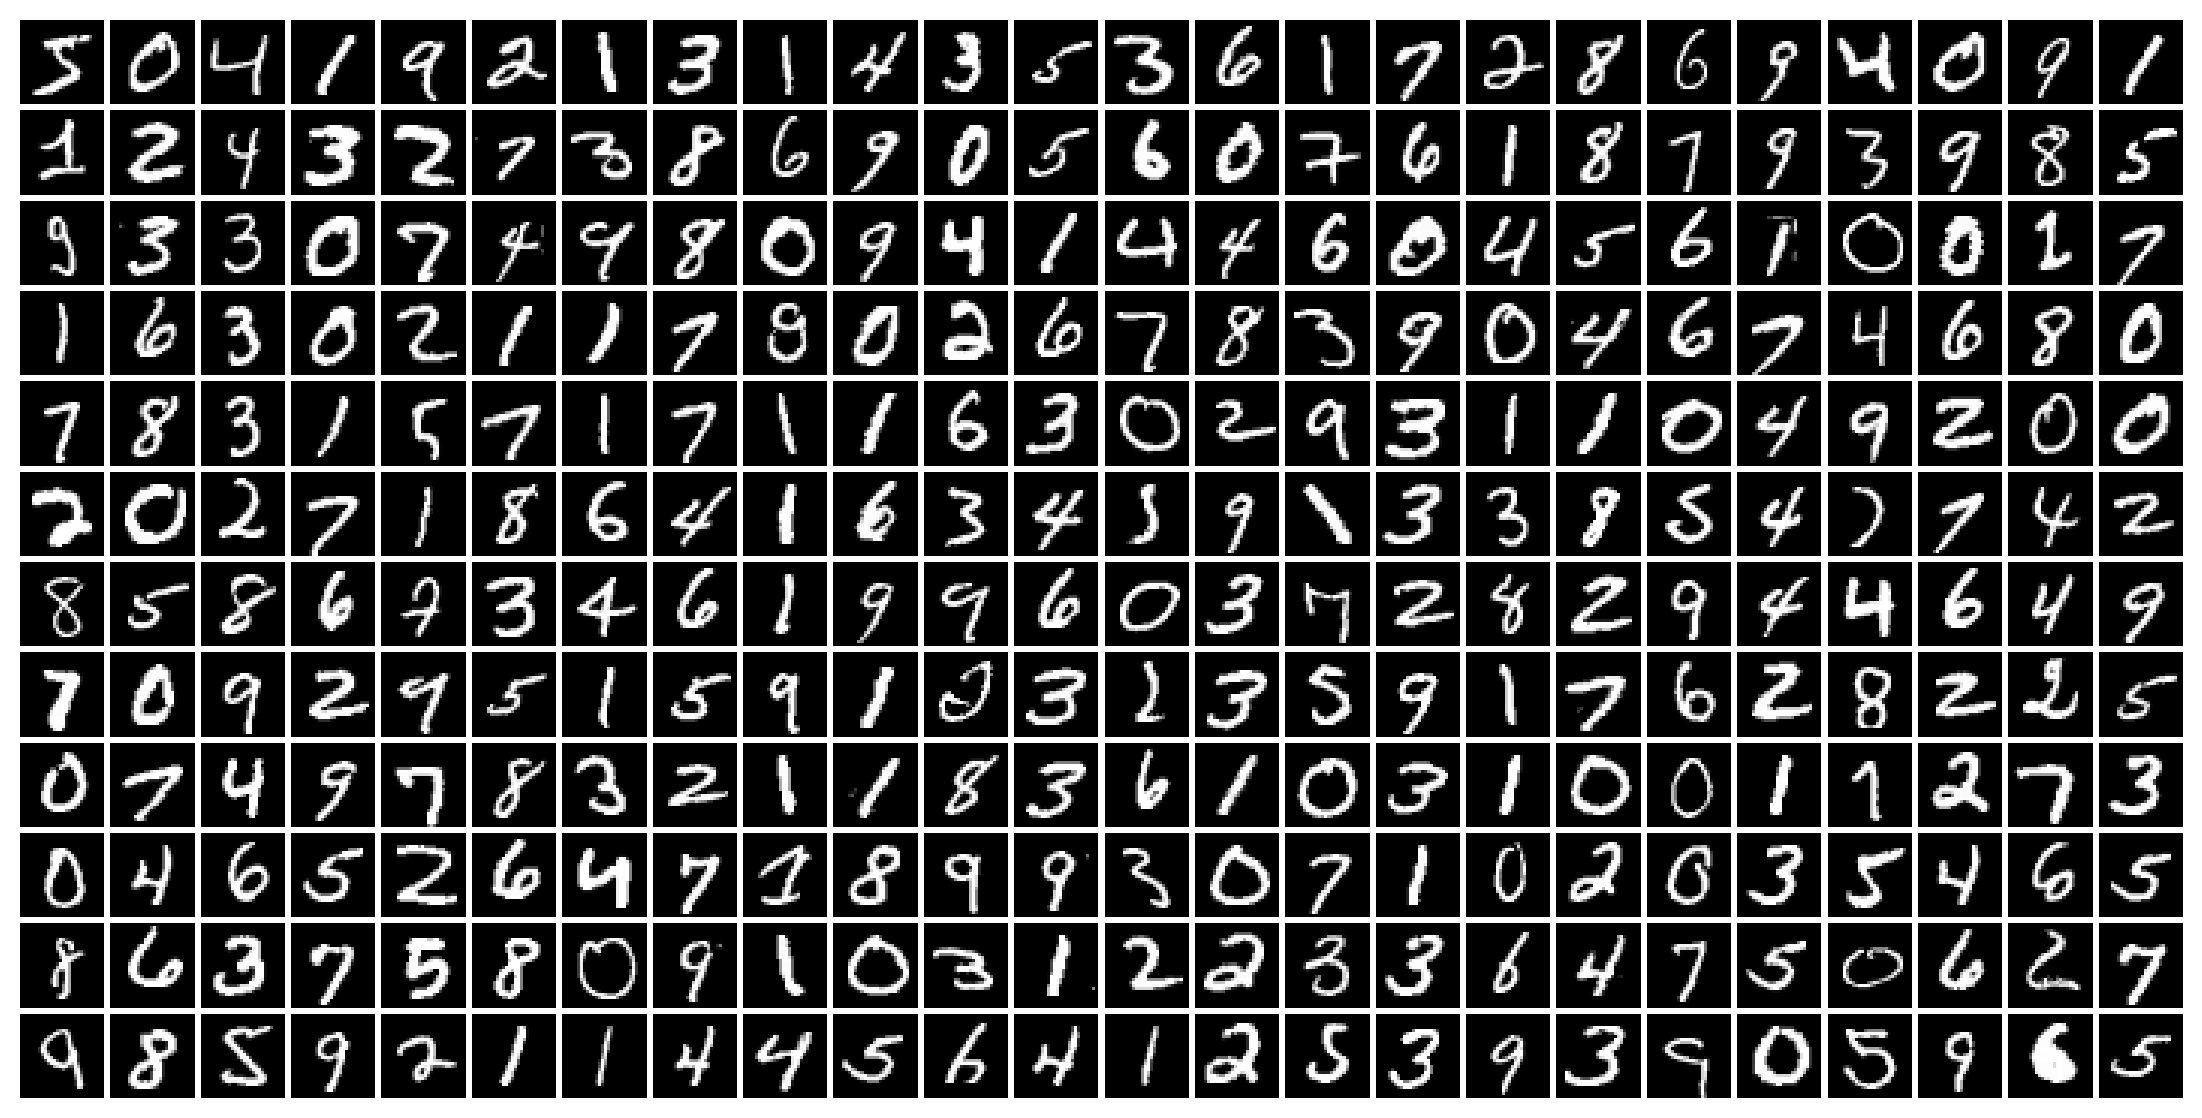

In [30]:
import mnist
mnist.datasets_url = "https://ossci-datasets.s3.amazonaws.com/mnist/"

fig = plt.figure(figsize=(14, 7))
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(plt.gca(), digits)

We will reshape each $28 \times 28$ pixel image into a $1 \times 784$ vector and append a fixed $1$ at the end. We will also convert images from $255$ from 255255 gray levels to $\langle 0, 1 \rangle$ interval. Finally, we will pick a random subset of 20,000 examples for training. The test part of the MNIST dataset will be used for validation.

In [31]:
##### Train set #####

DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_train_images.shape[0], 1))
mnist_train_images = np.concatenate((mnist_train_images, ones), axis=1)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

##### Validation set #####

mnist_val_images = mnist.test_images().astype(np.float32) / 255.0
mnist_val_images = np.reshape(mnist_val_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))

ones = np.ones((mnist_val_images.shape[0], 1))
mnist_val_images = np.concatenate((mnist_val_images, ones), axis=1)

mnist_val_labels = mnist.test_labels()
mnist_val_labels = one_hot_encode(mnist_val_labels)

## Multinomial logistic regression model

Our goal is to fit a multinomial logistic regression model to the MNIST dataset. We start by implementing the link function in this model.

### Softmax link function

Implement `softmax` function which takes an $n \times k$ matrix $\mathbf{Z}$ with class logits and returns an $n \times k$ matrix with categorical probability distributions for observations in $\mathbf{Z}$. The dimensions are: $n$ - number of observations, $k$ - number of classes.

---

**Implementation note**. Imagine that $z_{ij} = 100$. Then in a typical floating-point precision we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij}}}{\mathrm{e}^{z_{ij}} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{100}}{\mathrm{e}^{100} + \sum_{\substack{l=1 \\ l \neq j}}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{inf}}{\mathrm{inf}} = \mathrm{nan}
$$

However, note that for every finite $u \in \mathbb{R}$ we have:

$$\large
p_{ij} = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{-u} \mathrm{e}^{z_{ij}}}{\mathrm{e}^{-u} \sum_{l=1}^k \mathrm{e}^{z_{il}}}
       = \frac{\mathrm{e}^{z_{ij} - u}}{\sum_{l=1}^k \mathrm{e}^{z_{il} - u}}
$$

So to implement `softmax` in a numerically stable manner, we can simply shift the logits (independently for each observation) so that: $\mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il} = 0$. That is, we set:

$$\large
z_{ij} \leftarrow z_{ij} - \mathop{\mathrm{max}}_{l = 1,\ldots, k} z_{il}
$$

This basically turns an overflow issue into an underflow that we can disregard. Use this trick when implementing `softmax` function.

In [32]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    sum_exp_Z = np.sum(exp_Z, axis=1).reshape(-1, 1)
    
    return exp_Z / sum_exp_Z

### Cost function

Next, we need to implement a cost function for our model and its gradient w.r.t the model parameters. Note that the cross-entropy cost increases proportionally to the number of input observations $n$. This is undesirable from an optimization point of view: the learning rate in gradient descent needs to be adjusted to the number of training observations. To avoid that issue we will calculate an <u>average</u> cross-entropy cost per input observation. That is, we will divide the cross-entropy cost (and therefore also its gradient) by $n$.

---

Implement `xentropy` function which takes as an input:
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for $n$ input observations.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for $n$ input observations.

and returns an average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$.



In [33]:
def xentropy(S, T):
    return -np.sum(T * np.log(S), keepdims=True) / S.shape[0]

Implement `grad_xentropy` function which takes as an input:
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.
- An $n \times k$ matrix $\mathbf{S}$ with categorical probability distributions for observations in $\mathbf{X}$.
- An $n \times k$ matrix $\mathbf{T}$ with one-hot encoded class labels for observations in $\mathbf{X}$.

and returns a gradient of the average (per input observation) cross-entropy between $\mathbf{T}$ and $\mathbf{S}$. We assume a standard multinomial logistic regression parametrization:

\begin{align} \large
\mathbf{S}_{ij} & = \frac{\mathrm{e}^{z_{ij}}}{\sum_{l=1}^k \mathrm{e}^{z_{il}}}, \\[1em]
\left[z_{ij}\right]_{n \times k} & = \mathbf{Z} = \mathbf{XW},
\end{align}

and return the gradient w.r.t the model parameters: $\mathbf{W}_{\left(d+1\right) \times k}$.

In [34]:
def grad_xentropy(X, S, T):
    return X.T @ (S - T) / S.shape[0]

### Gradient descent training

We are now ready to implement a maximum likelihood estimation for multinomial logistic regression model. We begin with few utility functions.

Implement `classify` function which takes as an input
- An $(d+1) \times k$ matrix $\mathbf{W}$ with parameters of a multinomial logistic regression model.
- An $n \times (d+1)$ matrix $\mathbf{X}$ with explanatory variables for $n$ input observations.

and returns an $n \times k$ NumPy array with predicted class labels in one-hot encoding. We assume that the class predicted for a given observation is the one with the largest probability.

In [40]:
def classify(W, X):
    sf_max = softmax(X @ W)
    return (sf_max == np.max(sf_max, axis=1, keepdims=True))

In [41]:
def calc_acc(P, T):
    '''
    Calculate classification accuracy.
    
    Args:
        P: predicted labels in one-hot encoding,
           shape n times k.
        T: true labels in one-hot encoding,
           shape n times k.           
    
    Returns:
        Percentage of correctly predicted labels.
    '''
    accuracy = np.sum(P * T) / P.shape[0]
    return 100.0 * accuracy


def print_log(step, cost, train_acc, val_acc):
    '''
    A utility function used to display the progress of gd_fit.
    '''
    log = 'Step {:3d}\tcost value: {:5.2f},\ttrain accuracy: {:5.2f},\t' \
          'validation accuracy: {:5.2f}'
    log = log.format(step, cost.item(), train_acc.item(), val_acc.item())
    
    print(log)


We will minimize the cost function with gradient descent. Complete the implementation of `gd_fit` function following comments in the code.

In [42]:
def gd_fit(W0, X, T, X_val, T_val, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the cost function and store it in `cost_val` variable.
        
        sf_max = softmax(X @ W)
        cost_val = xentropy(sf_max, T)
        
        # Next, calculate the gradient of the cost function w.r.t the parameters
        # in `W`. Use this gradient matrix to update `W` (according to the gradient
        # descent update rule).
        
        grad = grad_xentropy(X, sf_max, T)
        W -= lr * grad
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

## Fitting multinomial logistic regression model to MNIST.

Lets prepare and plot some initial parameter values.

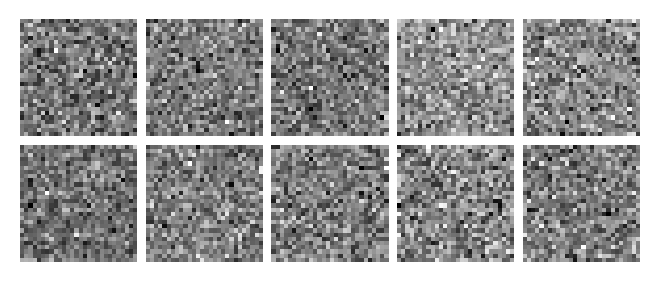

In [43]:
W0 = np.random.randn(DIGIT_SIZE*DIGIT_SIZE + 1, 10)

fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W0)

We can now fit multinomial logistic regression model to the MNIST dataset. Initially we do 200 gradient descent steps starting from `W0`.

In [44]:
W = gd_fit(W0,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=3.0, steps=200, log_every=10)

Step   1	cost value: 14.12,	train accuracy: 22.04,	validation accuracy: 21.78
Step  10	cost value:  2.74,	train accuracy: 60.47,	validation accuracy: 60.82
Step  20	cost value:  2.27,	train accuracy: 72.00,	validation accuracy: 73.08
Step  30	cost value:  1.34,	train accuracy: 77.91,	validation accuracy: 78.84
Step  40	cost value:  1.02,	train accuracy: 81.09,	validation accuracy: 82.42
Step  50	cost value:  0.93,	train accuracy: 82.16,	validation accuracy: 83.08
Step  60	cost value:  0.89,	train accuracy: 82.56,	validation accuracy: 83.48
Step  70	cost value:  0.83,	train accuracy: 83.22,	validation accuracy: 84.27
Step  80	cost value:  0.77,	train accuracy: 84.16,	validation accuracy: 85.07
Step  90	cost value:  0.73,	train accuracy: 84.80,	validation accuracy: 85.54
Step 100	cost value:  0.70,	train accuracy: 85.12,	validation accuracy: 85.84
Step 110	cost value:  0.68,	train accuracy: 85.27,	validation accuracy: 85.95
Step 120	cost value:  0.66,	train accuracy: 85.62,	validation ac

Next, we continue with additional 300 steps using a lower learning rate.

In [45]:
W = gd_fit(W,
           mnist_train_images, mnist_train_labels,
           mnist_val_images, mnist_val_labels,
           lr=0.3, steps=300, log_every=25)

Step   1	cost value:  0.53,	train accuracy: 87.93,	validation accuracy: 87.85
Step  25	cost value:  0.48,	train accuracy: 88.76,	validation accuracy: 88.60
Step  50	cost value:  0.48,	train accuracy: 88.80,	validation accuracy: 88.59
Step  75	cost value:  0.48,	train accuracy: 88.82,	validation accuracy: 88.59
Step 100	cost value:  0.48,	train accuracy: 88.88,	validation accuracy: 88.57
Step 125	cost value:  0.47,	train accuracy: 88.91,	validation accuracy: 88.62
Step 150	cost value:  0.47,	train accuracy: 88.94,	validation accuracy: 88.66
Step 175	cost value:  0.47,	train accuracy: 88.96,	validation accuracy: 88.66
Step 200	cost value:  0.47,	train accuracy: 89.01,	validation accuracy: 88.65
Step 225	cost value:  0.46,	train accuracy: 89.03,	validation accuracy: 88.65
Step 250	cost value:  0.46,	train accuracy: 89.06,	validation accuracy: 88.66
Step 275	cost value:  0.46,	train accuracy: 89.10,	validation accuracy: 88.70
Step 300	cost value:  0.46,	train accuracy: 89.14,	validation ac

Let's plot the fitted parameters.

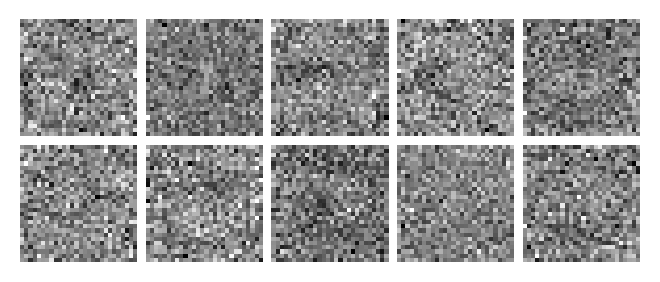

In [23]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W)

## Fitting regularized multinomial logistic regression model to MNIST.

Cross entropy cost function is convex but it is <u>not</u> strictly convex. We can turn it into a strictly convex cost function by adding a regularization term that penalizes magnitudes of model parameters:

$$ \large
\mathcal{L}_R\left(\mathbf{W}\right) = \mathcal{L}\left(\mathbf{W}\right) +
                                       \frac{\lambda}{2}\sum_{i=1}^{d+1}\sum_{j=1}^k w_{ij}^2,
$$

where $\mathcal{L}\left(\mathbf{W}\right)$ is the cross entropy cost.

This is the same regularization that we used in ridge regression, and it can be derived as a MAP estimate in a Bayesian logistic regression model with Gaussian prior on model parameters (we do not need a conjugate prior to find the cost function for a MAP estimate). Let's implement this variant of the logistic regression model.

Complete the implementation of `gd_fit_reg` function following comments in the code.

In [26]:
def gd_fit_reg(W0, X, T, X_val, T_val, l2=0.005, lr=1.0, steps=100, log_every=5):
    '''
    Fit multinomial logistic regression model with gradient descent.
    
    Args:
        W0:        An array with initial parameter values, shape (d+1) times k.
        X:         An array with explanatory variables for input (train) observations,
                   shape n times (d+1).
        T:         An array with one-hot encoded class labels for input (train) observations, 
                   shape n times k.
        X_val:     An array with explanatory variables for validation observations,
                   shape m times (d+1).
        T_val:     An array with one-hot encoded class labels for validation observations, 
                   shape m times k.
        l2:        The regularization strength (\lambda hyper-paramater).
        lr:        Learning rate.
        steps:     Number of gradient descent steps to perform.
        log_every: Number of steps between progress logs.
    
    Returns:
        An (d+1) times k NumPy array with fitted parameters.
    '''
    n = X.shape[0]
    W = np.copy(W0)
    
    for step in range(steps):
        # Assuming that current model parameters are in `W`, calculate the value of
        # the regularized cost function and store it in `cost_val` variable.
        
        sf_max = softmax(X @ W)
        cost_val = xentropy(sf_max, T) + l2 / 2 * np.sum(W * W)
        
        # Next, calculate the gradient of the regularized cost function w.r.t the
        # parameters in `W`. Use this gradient matrix to update `W` (according to
        # the gradient descent update rule).
        
        W = W - lr * grad_xentropy(X, sf_max, T) - W * l2
        
        
        
        P_train = classify(W, X)
        train_acc = calc_acc(P_train, T)
        
        P_val = classify(W, X_val)
        val_acc = calc_acc(P_val, T_val)
        
        if step == 0 or (step + 1) % log_every == 0:
            print_log(step+1, cost_val, train_acc, val_acc)
    
    return W

Let's fit regularized multinomial logistic regression model to the MNIST dataset.

In [27]:
W_reg = gd_fit_reg(W0,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=3.0,
                   steps=200, log_every=10)

Step   1	cost value: 33.54,	train accuracy: 16.16,	validation accuracy: 15.57
Step  10	cost value: 17.92,	train accuracy: 64.63,	validation accuracy: 64.93
Step  20	cost value: 13.11,	train accuracy: 69.25,	validation accuracy: 69.04
Step  30	cost value:  9.70,	train accuracy: 74.17,	validation accuracy: 73.86
Step  40	cost value:  7.27,	train accuracy: 76.35,	validation accuracy: 76.33
Step  50	cost value:  6.41,	train accuracy: 70.97,	validation accuracy: 70.73
Step  60	cost value:  4.60,	train accuracy: 72.72,	validation accuracy: 72.79
Step  70	cost value:  3.63,	train accuracy: 74.36,	validation accuracy: 74.25
Step  80	cost value:  3.99,	train accuracy: 72.35,	validation accuracy: 72.01
Step  90	cost value:  2.80,	train accuracy: 74.78,	validation accuracy: 74.28
Step 100	cost value:  2.51,	train accuracy: 75.44,	validation accuracy: 75.01
Step 110	cost value:  2.19,	train accuracy: 77.89,	validation accuracy: 77.47
Step 120	cost value:  2.29,	train accuracy: 67.99,	validation ac

In [28]:
W_reg = gd_fit_reg(W_reg,
                   mnist_train_images, mnist_train_labels,
                   mnist_val_images, mnist_val_labels,
                   l2=0.005, lr=0.3,
                   steps=300, log_every=25)

Step   1	cost value:  3.53,	train accuracy: 79.77,	validation accuracy: 80.44
Step  25	cost value:  0.80,	train accuracy: 89.55,	validation accuracy: 90.03
Step  50	cost value:  0.73,	train accuracy: 90.05,	validation accuracy: 90.43
Step  75	cost value:  0.68,	train accuracy: 90.33,	validation accuracy: 90.62
Step 100	cost value:  0.65,	train accuracy: 90.55,	validation accuracy: 90.79
Step 125	cost value:  0.61,	train accuracy: 90.70,	validation accuracy: 91.02
Step 150	cost value:  0.58,	train accuracy: 90.86,	validation accuracy: 91.08
Step 175	cost value:  0.56,	train accuracy: 91.03,	validation accuracy: 91.20
Step 200	cost value:  0.54,	train accuracy: 91.11,	validation accuracy: 91.24
Step 225	cost value:  0.53,	train accuracy: 91.20,	validation accuracy: 91.28
Step 250	cost value:  0.52,	train accuracy: 91.22,	validation accuracy: 91.31
Step 275	cost value:  0.51,	train accuracy: 91.27,	validation accuracy: 91.43
Step 300	cost value:  0.50,	train accuracy: 91.29,	validation ac

Finally we plot the parameters of the regularized model.

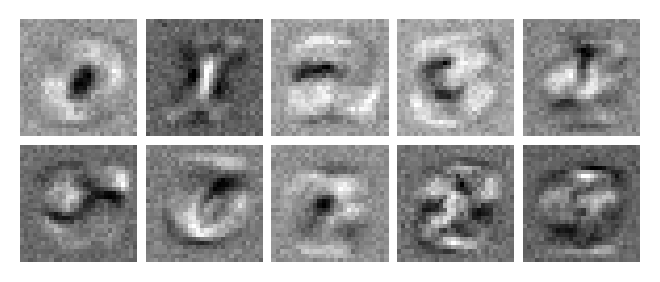

In [29]:
fig = plt.figure(figsize=(4, 2))
draw_params(plt.gca(), W_reg)